# Packages and lib imports

In [9]:
# initial setup for any notebook

%load_ext autoreload
%autoreload 2
import sys
sys.path.append("/home/yarcoh/projects/thesis-code4") # go to parent dir

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [10]:
# imports

from src.deep.model_analyzer_src import ModelAnalyzer
from src.deep.models import *
from src.deep.trainers import Trainer
from src.general_methods.visualizer import Visualizer
from src.optics.config_manager import ConfigManager

from tqdm.notebook import tqdm
import os


# Parameters configuration

In [11]:

trained_model_path = '/data/yarcoh/thesis_data/data/prod_models/unet_v5_depth9_30k_M32_noised_b1_mu043_noreg_v1'
main_ds_path = '/data/yarcoh/thesis_data/data/datasets/b1/30000samples_15mu_W01'
ds_subdir = 'mu=0.42'
# main_ds_path = '/data/yarcoh/thesis_data/data/datasets/100000samples_20mu/'
# ds_subdir = '100000_samples_mu=0.200'
model_name = os.path.basename(trained_model_path)
datasetpath = os.path.join(main_ds_path, ds_subdir)

# Init

In [12]:
# load trainer from file
trainer: Trainer = Trainer.load3(trained_model_path)

In [13]:
conf = trainer.train_dataset.config
conf.__dict__


{'W': 0.05,
 'Nspans': 12,
 'La': 80,
 'M_QAM': 16,
 'Ts': 1.0,
 'Nos': 16,
 'eta': 2,
 'mu': 0.43157894736842106,
 'bet': 0.2,
 'with_ssf': True,
 'with_noise': True,
 'beta2': -21.0,
 'gamma': 1.27,
 'dz': 0.2,
 'K_T': 1.13,
 'chi': 0.0461,
 'verbose': False,
 'io_type': 'b1',
 'N_sc': 256,
 'T_guardband': 4750.0880922277665,
 'N_sc_raw': 237.50440461138834,
 'L': 960,
 'T0': 5120.0,
 'Tb': 10240.0,
 'Tn': 1358.1221810508403,
 'Zn': 87833.13612677579,
 'Pn': 8.964743939765935e-06,
 'Ns': 4096,
 'Nnft': 16384,
 'Tnft': 68266.66666666667,
 'dt': 4.166666666666667,
 'Nb': 2458,
 'T1': -25.132741228718345,
 'T2': 25.12967326714258,
 'XI': array([-511.9375,  512.    ])}

In [14]:
# for broken models with old config

# inp = input('Do you want to refresh config? (y/n) ')
# if inp == 'y':
#     trainer.train_dataset.config = ConfigManager.refresh_config(trainer.train_dataset.config)
#     trainer.save(trained_model_path)
# else:
#         print('config not refreshed')

In [15]:
ma: ModelAnalyzer = ModelAnalyzer(trainer,model_name)

In [16]:
ma.load_test_dataset(datasetpath, train_ds_ratio=0.4, val_ds_ratio=0.3, test_ds_ratio=0.3)

In [17]:
trainer.print_summary()

/home/yarcoh/projects/thesis-code4/src/deep/data_loaders.py:235: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  /opt/conda/conda-bld/pytorch_1659484808560/work/torch/csrc/utils/tensor_new.cpp:201.)
  t = torch.Tensor([np_vec.real, np_vec.imag])


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv1d-1                 [-1, 1024]             224
              Tanh-2                 [-1, 1024]               0
         MaxPool1d-3                  [-1, 512]               0
            Conv1d-4                  [-1, 512]           6,208
              Tanh-5                  [-1, 512]               0
         MaxPool1d-6                  [-1, 256]               0
            Conv1d-7                  [-1, 256]          24,704
              Tanh-8                  [-1, 256]               0
         MaxPool1d-9                  [-1, 128]               0
           Conv1d-10                  [-1, 128]          98,560
             Tanh-11                  [-1, 128]               0
        MaxPool1d-12                   [-1, 64]               0
           Conv1d-13                   [-1, 64]         393,728
             Tanh-14                   

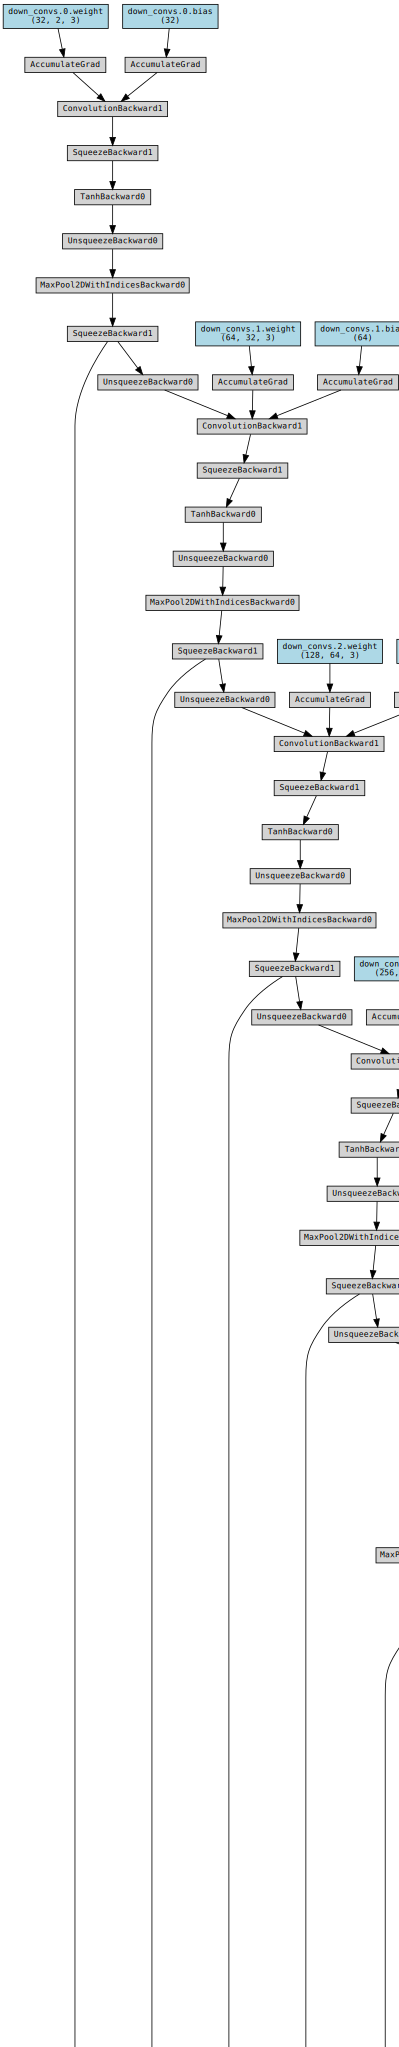

In [18]:
# plot architecture

# old method
# from IPython.display import Image
# path = f'{trained_model_path}/_analyze/architecture'
# trainer.plot_architecture(path)

# # Replace 'image_path' with the path to your image file
# Image(filename=path+'.png')

# new method
import torch
from torch import nn
from torchviz import make_dot

model = trainer.model
rx, tx, pred = trainer.get_single_item(0, format='torch')
make_dot(model(rx), params=dict(model.named_parameters()))

In [19]:
print(len(trainer.val_dataset))

9000


In [20]:
#pretty print ds config


# Visualizer.print_config(trainer.val_dataset.config)

# analyze 1 sample

In [21]:
print(ma.cs_in.channel_config.io_type)

c


In [22]:
# ma.plot_single_item(1)
# N = ma.cs_in.channel_config.Ns
# N = ma.cs_in.channel_config.N_sc
# ma.cs_in.channel_config.io_type
# ma.plot_single_item_together(i=1, zm_indices=range(N//2,N//2+50))

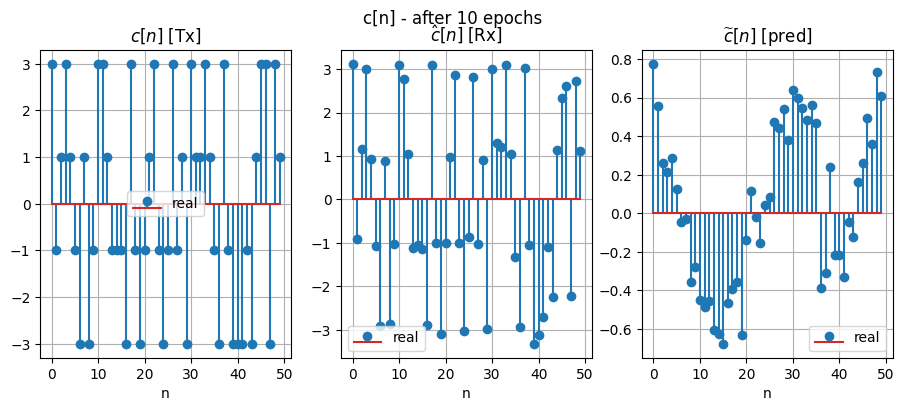

In [23]:
ma.plot_stems(i=1, zm_indices=range(0,50))

# analyze constelation

  0%|          | 0/40 [00:00<?, ?it/s]

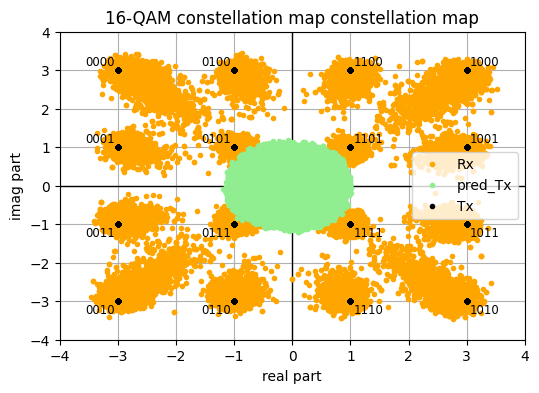

In [24]:
ma.plot_constelation(range(0,40), colors=['orange', 'lightgreen', 'black'])

In [25]:
# x_power_i, y_power, pred_power = ma.calc_norms(_tqdm=tqdm, verbose_level=1, max_items=10000)
# print(f'x_power: {x_power_i}\ny_power: {y_power}\npred_power: {pred_power}')

In [26]:
# ma.upload_single_item_plots_to_wandb(1)

In [27]:
ma.plot_bers(_tqdm=tqdm, verbose_level=1,num_x_per_folder=1000)

  0%|          | 0/1000 [00:00<?, ?it/s]

the original avg ber (of validation set) is 0.009607177734375


  0%|          | 0/1000 [00:00<?, ?it/s]

the trained avg ber (of validation set) is 0.437130126953125
the ber improvement is -4450.04%


In [28]:
ma.upload_bers_to_wandb()

the original avg ber (of validation set) is 0.009358208550347222


Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


the trained avg ber (of validation set) is 0.4371522894965278
the ber improvement is -4571.32%


wandb: Currently logged in as: yarden92. Use `wandb login --relogin` to force relogin


# test all BERs

In [29]:
# add powers

# from apps.deep.power_adder import PowerAdder


# power_adder = PowerAdder(is_overright=True, verbose_level=2)
# power_adder.calculate_and_add_powers(main_ds_path)
# power_adder.replace_key_in_config_files(main_ds_path)

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

mu=0.100 | org_ber=5.59e-03 | model_ber=4.37e-01 |  ber_improve=-7714%


  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

mu=0.140 | org_ber=2.38e-04 | model_ber=4.37e-01 |  ber_improve=-183130%


  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

mu=0.170 | org_ber=0.00e+00 | model_ber=4.36e-01 |  ber_improve=000%


  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

mu=0.210 | org_ber=0.00e+00 | model_ber=4.37e-01 |  ber_improve=000%


  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

mu=0.240 | org_ber=0.00e+00 | model_ber=4.36e-01 |  ber_improve=000%


  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

mu=0.280 | org_ber=0.00e+00 | model_ber=4.37e-01 |  ber_improve=000%


  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

mu=0.310 | org_ber=1.35e-05 | model_ber=4.36e-01 |  ber_improve=-3224013%


  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

mu=0.350 | org_ber=2.27e-04 | model_ber=4.37e-01 |  ber_improve=-191894%


  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

mu=0.390 | org_ber=2.69e-03 | model_ber=4.37e-01 |  ber_improve=-16109%


  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

mu=0.420 | org_ber=9.62e-03 | model_ber=4.38e-01 |  ber_improve=-4448%


  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

mu=0.460 | org_ber=2.34e-02 | model_ber=4.37e-01 |  ber_improve=-1766%


  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

mu=0.490 | org_ber=4.52e-02 | model_ber=4.39e-01 |  ber_improve=-871%


  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

mu=0.530 | org_ber=7.58e-02 | model_ber=4.39e-01 |  ber_improve=-479%


  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

mu=0.560 | org_ber=1.12e-01 | model_ber=4.41e-01 |  ber_improve=-295%


  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

mu=0.600 | org_ber=1.50e-01 | model_ber=4.42e-01 |  ber_improve=-195%


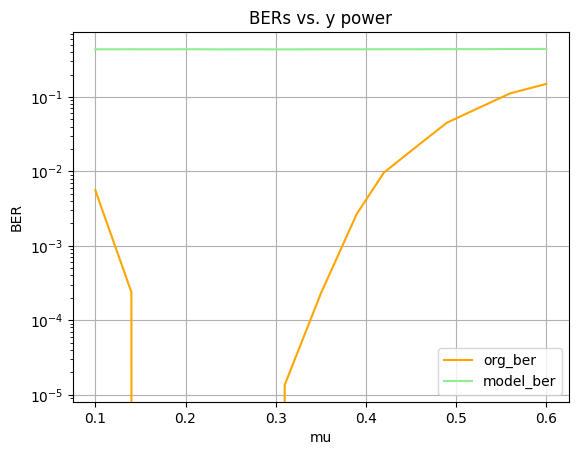

In [30]:
# main_ds_path = '/data/yarcoh/thesis_data/data/datasets/qam16_50x300/'

ma.plot_all_bers(base_path=main_ds_path, 
                 train_ds_ratio=0, 
                 val_ds_ratio=0, 
                 test_ds_ratio=0.05, 
                 _tqdm=tqdm, 
                 verbose_level=0.5,
                 is_upload_to_wandb=True)
                    

In [31]:
# upload to wandb
# ma.upload_all_bers_to_wandb(base_path=main_ds_path,
#                  train_ds_ratio=0, 
#                  val_ds_ratio=0, 
#                  test_ds_ratio=0.15, 
#                  _tqdm=tqdm, 
#                  verbose_level=0.5)

In [32]:
print('done')

done


# THE END

In [33]:
# # paper 1 model analyzer
# path_init = '../../data/test_models/mu-0.008__128ds__PaperNNforNFTmodel__3epochs'

# trainer_real = Trainer.load3(path_init + '__real')
# trainer_imag = Trainer.load3(path_init + '__imag')

# train_ds = SingleMuDataSet(trainer_real.train_dataset.data_dir_path,
#                            trainer_real.train_dataset.data_indices)
# val_ds = SingleMuDataSet(trainer_real.val_dataset.data_dir_path,
#                          trainer_real.val_dataset.data_indices)

# model = PaperNNforNFTwrapper(trainer_real.model, trainer_imag.model)

# trainer = Trainer(
#     train_dataset=train_ds,
#     val_dataset=val_ds,
#     model=model,
#     device=trainer_real.device,
#     batch_size=trainer_real.train_dataloader.batch_size,
#     l_metric=trainer_real.l_metric,
#     optim=trainer_real.optim,
#     params=trainer_real.params)

In [34]:
# analyze on the whole dataset

# attach new dataset to trainer


In [35]:
# trainer.params

In [36]:
# ma = ModelAnalyzer(trainer)

In [37]:
# ma.plot_single_item(i=0)

In [38]:
# ma.plot_bers(_tqdm=tqdm)